In [1]:
%matplotlib inline

import pymc as pm
print(f"pyMC version: {pm.__version__}")

import numpy as np
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import seaborn as sns

import scipy.stats

import logging

import pytensor
import pytensor.tensor as pt
from pytensor import scan
# pytensor.config.floatX = "float64"

from datetime import date
import os
import pickle

pyMC version: 5.0.2


### Import existing model that has been fit

In [2]:
import importlib
import model
importlib.reload(model)

basepath = '/Users/hwunrow/Documents/GitHub/rt-estimation/data/'
dirs = os.listdir(basepath)

In [3]:
with open(f"{basepath}/2023-02-05_NUTS_likelihood_normal_add_noise_in_mcmc_clip_before_noise/model.pkl", 'rb') as file:
# with open(f"{basepath}/2023-02-07_NUTS_likelihood_students-t/model.pkl", 'rb') as file:
    sir_model = pickle.load(file)

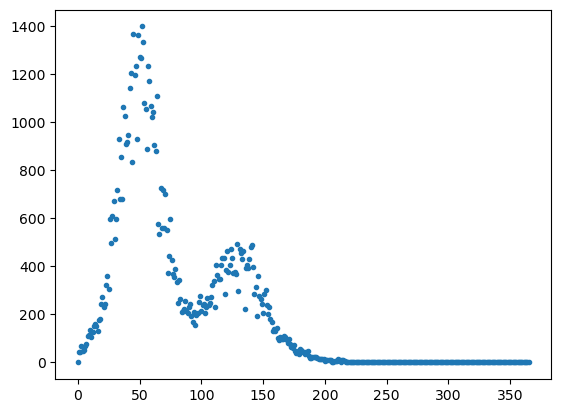

In [4]:
plt.plot(sir_model.data.i, '.')

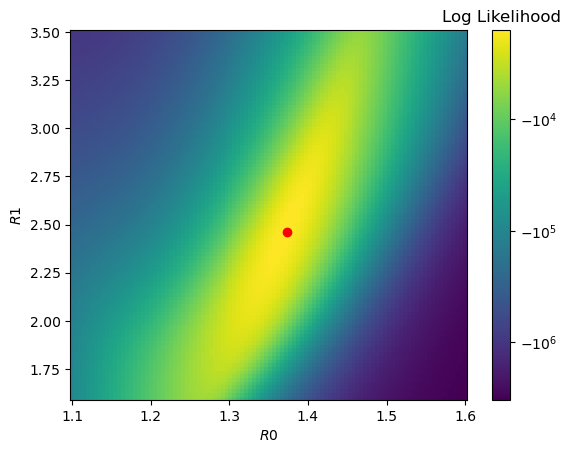

In [5]:
from matplotlib.colors import SymLogNorm

def interval_transform(v, a, b):
    return np.log(v-a) - np.log(b-v)
# at.log(value - a) - at.log(b - value)

rt_0s = np.linspace(1.1, 1.6, 100)
rt_1s = np.linspace(1.6, 3.5, 100)

rt_0_interval = interval_transform(rt_0s, 1., 4.)
rt_1_interval = interval_transform(rt_1s, 1.5, 4.)

rt_0_intervals, rt_1_intervals = np.meshgrid(rt_0_interval, rt_1_interval)

logp = sir_model.model.compile_logp()

def likelihood(rt_0_interval, rt_1_interval):
    return logp({
     'rt_0_interval__': rt_0_interval,
     'rt_1_interval__': rt_1_interval,
     'k_interval__': .405,
     'midpoint': 100,
     'I0': 100,
     'sigma_log__': -1.61})

f = np.vectorize(likelihood)
liks = f(rt_0_intervals, rt_1_intervals)

# Get the maximum "lik"
rt_1_ix, rt_0_ix = np.unravel_index(np.argmax(liks), liks.shape)

plt.pcolor(rt_0s, rt_1s, liks, norm=SymLogNorm(0.5))
plt.xlabel(r'$R0$')
plt.ylabel(r'$R1$')
clb = plt.colorbar()
clb.ax.set_title('Log Likelihood')
plt.plot(rt_0s[rt_0_ix], rt_1s[rt_1_ix], 'or', label='maximum likelihood')

<AxesSubplot: xlabel='rt_0', ylabel='rt_1'>

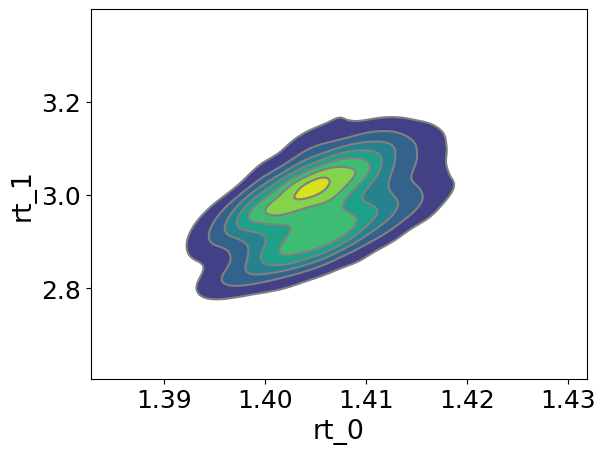

In [6]:
az.plot_pair(sir_model.trace,
             var_names=['rt_0', 'rt_1'],
             kind='kde',
             textsize=18)

In [7]:
# pm.find_MAP(model=sir_model.model)

### Plot likelihoods from new model (no observed data)

In [123]:
i = sir_model.data.i[1:]

t = np.arange(0, 365)
coords = {'day':t}

with pm.Model(coords=coords) as likelihood_sampler:
    sigma = pm.HalfCauchy("sigma", 10)
    student_t = pm.StudentT(
        "like_student_t",
        nu=4,
        mu=i,
        sigma=pt.abs(1+sigma*i),
        dims="day"
    )
    normal = pm.Normal(
        "like_normal",
        mu=i,
        sigma=pt.abs(1+sigma*i),
        dims="day"
    )
    alpha_inv = pm.Normal(name="alpha_inv", mu=0, sigma=0.5)
    alpha = pm.Deterministic(name="alpha", var=1 / pm.math.sqr(alpha_inv))
    neg_binom = pm.NegativeBinomial(
        "like_neg_binom",
        alpha=pt.abs(alpha+0.01),
        mu=i,
        dims="day"
    )

In [124]:
logp = likelihood_sampler.compile_logp(sum=False)

def likelihood(value, k):
    probs = logp({
        'sigma_log__': -1.60943,
        'like_student_t': np.repeat(value, 365),
        'like_normal': np.repeat(value, 365),
        'alpha_inv': 0.,
        'like_neg_binom': np.repeat(value, 365)})
    return probs[k]

f = np.vectorize(likelihood)
cases = np.arange(0, 5000)

liks1 = np.array([likelihood(case, 1) for case in cases])
liks2 = np.array([likelihood(case, 2) for case in cases])
liks3 = np.array([likelihood(case, 4) for case in cases])


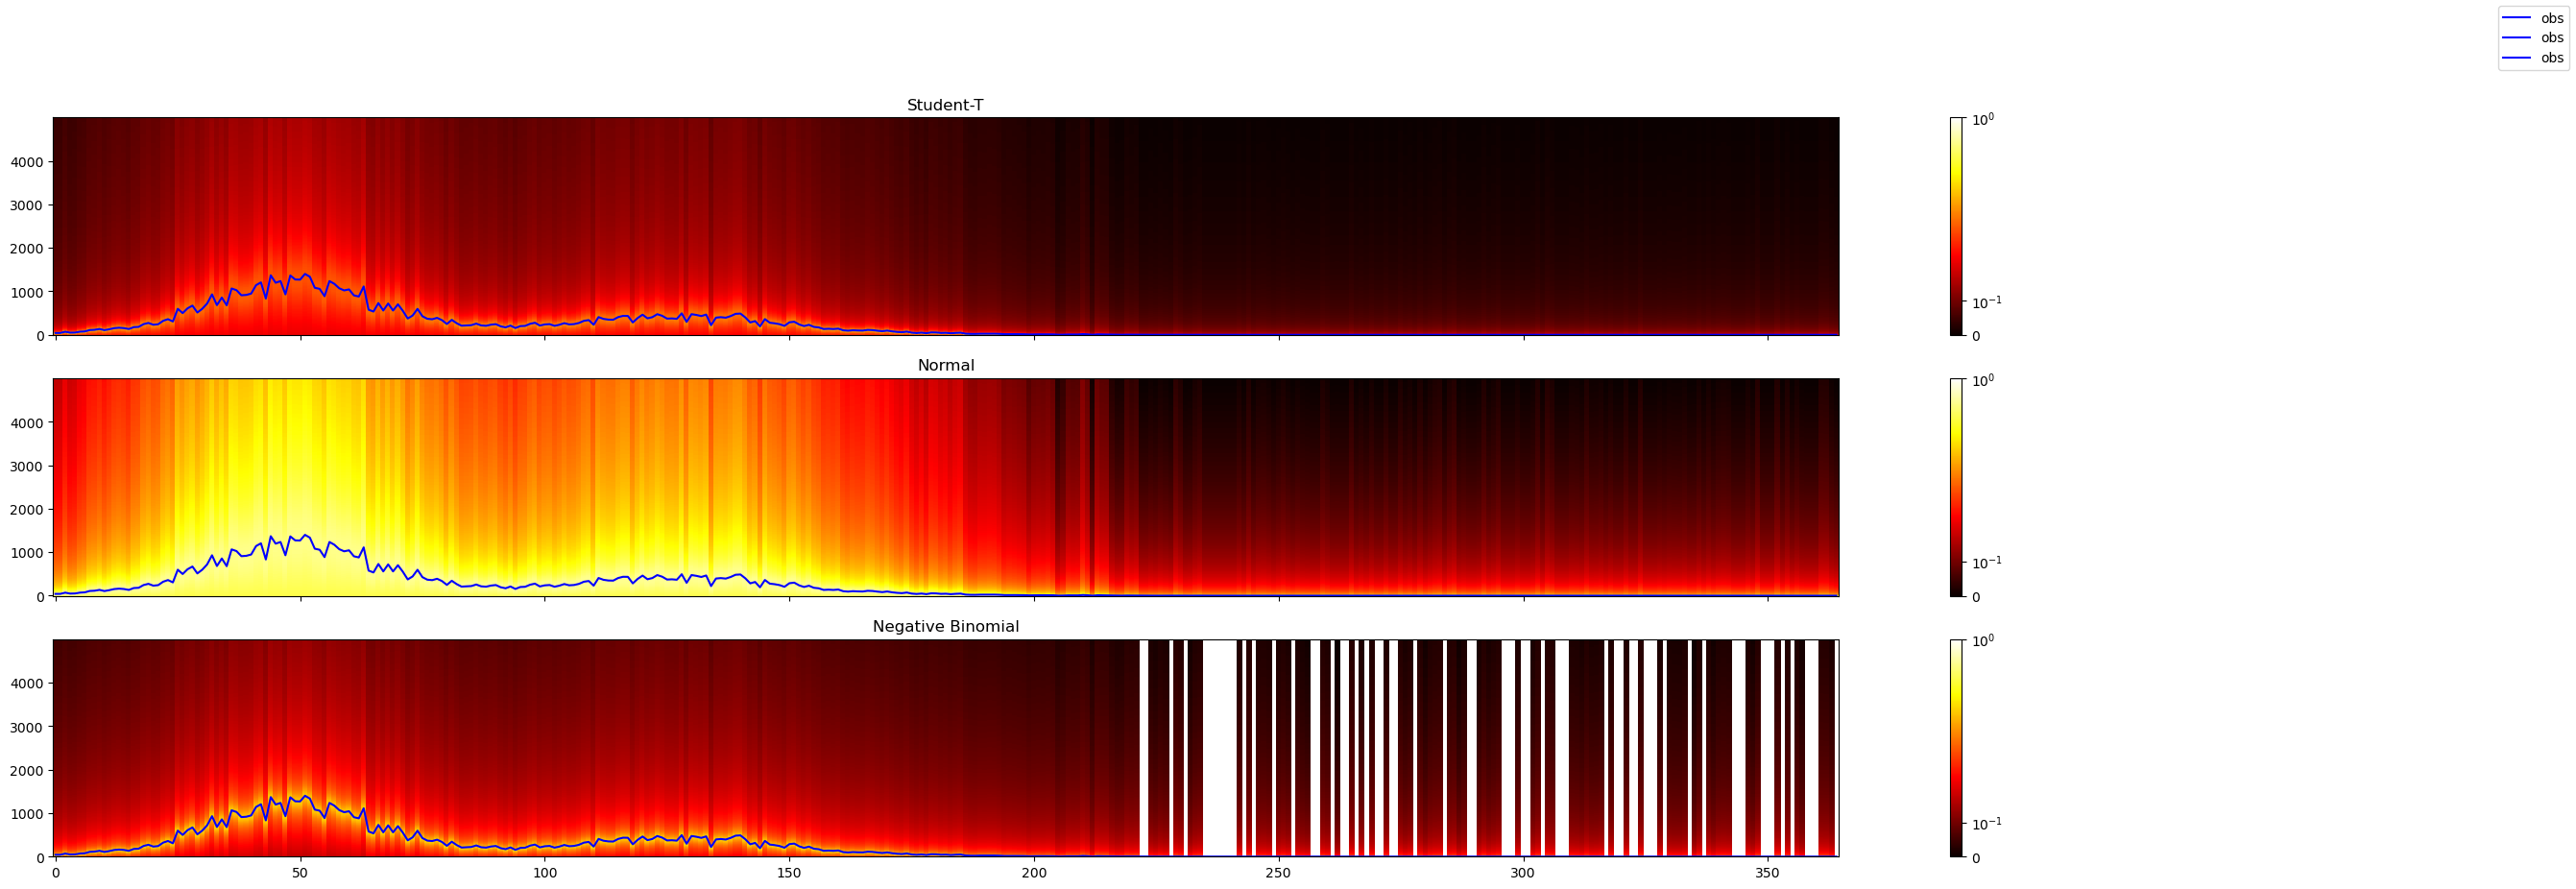

In [125]:
fig, ax = plt.subplots(3, figsize=(30,10), sharex=True)

norm = SymLogNorm(0.5)
cmap = 'hot'
sc = plt.cm.ScalarMappable(norm = norm, cmap =  cmap)

ax[0].pcolor(t, cases, np.array(liks1), norm=SymLogNorm(0.5), cmap=cmap)
ax[0].plot(t, i, '-', color='b', label='obs')
ax[0].title.set_text('Student-T')
fig.colorbar(sc, ax = ax[0])

ax[1].pcolor(t, cases, np.array(liks2), norm=SymLogNorm(0.5), cmap=cmap)
ax[1].plot(t, i, '-', color='b', label='obs')
ax[1].title.set_text('Normal')
fig.colorbar(sc, ax = ax[1])

im = ax[2].pcolor(t, cases, np.array(liks3), norm=SymLogNorm(0.5), cmap=cmap)
ax[2].plot(t, i, '-', color='b', label='obs')
ax[2].title.set_text('Negative Binomial')
fig.colorbar(sc, ax = ax[2])

# clb = fig.colorbar(im, ax=ax.ravel().tolist())
# clb.ax.set_title('Log Likelihood')
fig.legend()

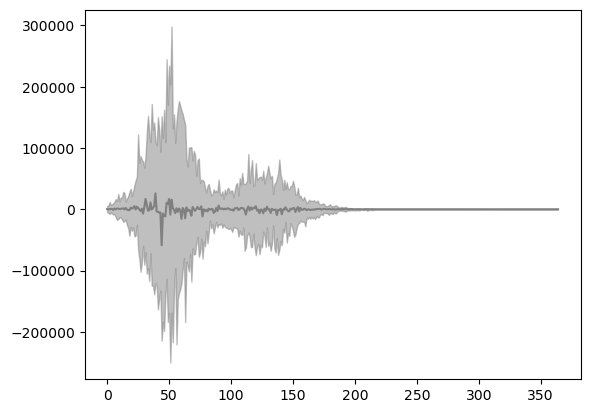

In [126]:
student_t_sample = pm.draw(student_t, draws=1000).T
student_t_mean = student_t_sample.mean(axis=1)
student_t_lower = np.quantile(student_t_sample, 0.025, axis=1)
student_t_upper = np.quantile(student_t_sample, 0.975, axis=1)

fig, ax = plt.subplots()

ax.plot(student_t_mean, '-', color='gray')
plt.fill_between(t,student_t_lower,student_t_upper, color='gray', alpha=0.5)

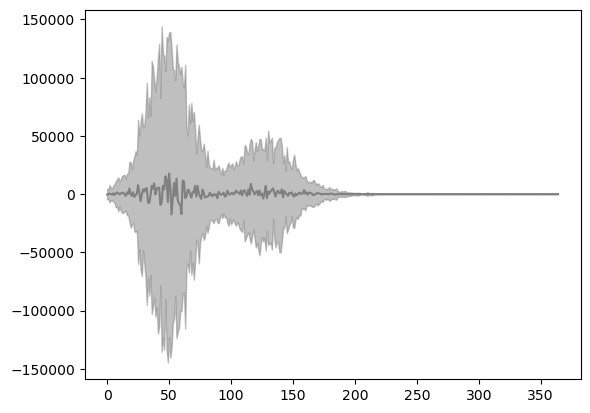

In [127]:
normal_sample = pm.draw(normal, draws=10000).T
normal_mean = normal_sample.mean(axis=1)
normal_lower = np.quantile(normal_sample, 0.025, axis=1)
normal_upper = np.quantile(normal_sample, 0.975, axis=1)

fig, ax = plt.subplots()

ax.plot(normal_mean, '-', color='gray')
plt.fill_between(t,normal_lower,normal_upper, color='gray', alpha=0.5)

In [128]:
neg_binom_sample = pm.draw(neg_binom, draws=10000).T
neg_binom_mean = neg_binom_sample.mean(axis=1)
neg_binom_lower = np.quantile(neg_binom_sample, 0.025, axis=1)
neg_binom_upper = np.quantile(neg_binom_sample, 0.975, axis=1)

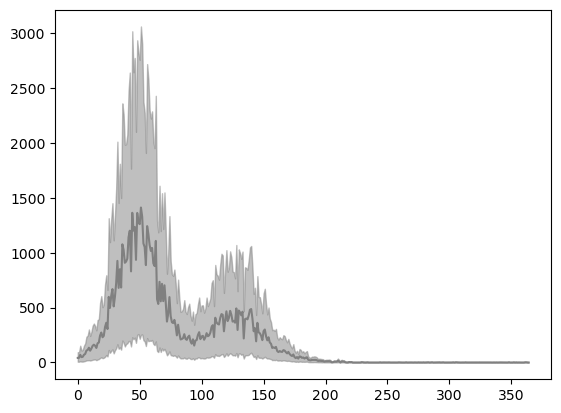

In [129]:
fig, ax = plt.subplots()

ax.plot(neg_binom_mean, '-', color='gray')
plt.fill_between(t,neg_binom_lower,neg_binom_upper, color='gray', alpha=0.5, label=['2.5 - 9.75'])


### Simple univariate plots (it = 100)

In [200]:
i_simple = 10

In [201]:
with pm.Model(coords=coords) as simple_likelihood_sampler:
    sigma = pm.HalfCauchy("sigma", 0.2)
    student_t = pm.StudentT(
        "like_student_t",
        nu=4,
        mu=i_simple,
        sigma=pt.abs(1+sigma*i_simple)
    )
    normal = pm.Normal(
        "like_normal",
        mu=i_simple,
        sigma=pt.abs(1+sigma*i_simple)
    )
    alpha_inv = pm.Normal(name="alpha_inv", mu=0, sigma=0.5)
    alpha = pm.Deterministic(name="alpha", var=1 / pm.math.sqr(alpha_inv))
    neg_binom = pm.NegativeBinomial(
        "like_neg_binom",
        alpha=pt.abs(alpha+0.01),
        mu=i_simple,
        dims="day"
    )

Text(0.5, 1.0, 'Likelihood Distributions with $i_t = 10$')

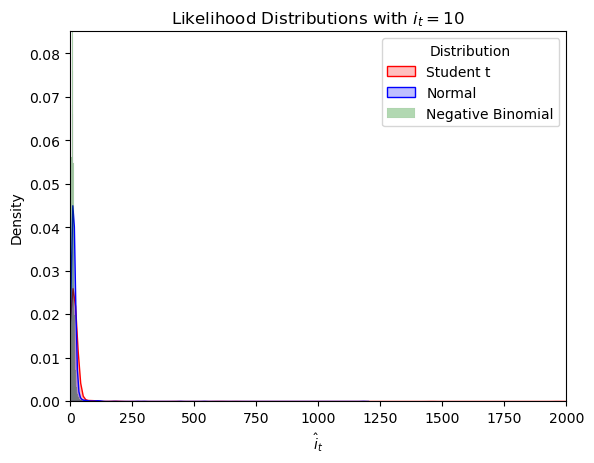

In [202]:
fig, ax = plt.subplots()

st_draws = pm.draw(student_t, draws=2000).T
st_draws = st_draws[(st_draws < 2000) & (st_draws >= 0)]
sns.kdeplot(st_draws, fill=True, color='r', label=r'Student t', ax=ax).set(xlabel=r'$\hat{i}_t$')

n_draws = pm.draw(normal, draws=2000).T
n_draws = n_draws[(n_draws < 2000) & (n_draws >= 0)]
sns.kdeplot(n_draws, fill=True, color='b', ax=ax).set(label=r'Normal', xlabel=r'$\hat{i}_t$')

nb_draws = pm.draw(neg_binom, draws=2000).T
nb_draws = nb_draws[(nb_draws < 2000) & (nb_draws >= 0)]
sns.histplot(nb_draws, color='g', fill=True, alpha=0.3, discrete=True, stat='probability', ax=ax)

ax.set_xlim(0, 2000)
ax.set_ylim(0, 0.085)

plt.legend(title='Distribution', loc='upper right', labels=['Student t', 'Normal', 'Negative Binomial'])
plt.title(rf'Likelihood Distributions with $i_t = {i_simple}$')